In [ ]:
from google.colab import files

print('Please load  anthropometric_data.csv file:')
uploaded = files.upload()

for filename in uploaded.keys():
  print(f'Uploaded file: {filename}')

Please load  anthropometric_data.csv file:


Saving anthropometric_data.csv to anthropometric_data.csv
Uploaded file: anthropometric_data.csv


Dosyayı başarıyla yükledikten sonra, diğer hücreleri çalıştırabilirsiniz. 'anthropometric_data.csv' dosyasını yükledikten sonra diğer kod hücrelerini çalıştırmama hazır olduğunuzda bana haber verin.

In [ ]:
# ============================================================================
# SUSTAINABLE SIZING PROJECT - DAY 2: EDA & CORRELATION ANALYSIS
# ============================================================================
# Goal: Discover which measurements predict each other (identify body types)
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Load data from Day 1
df = pd.read_csv('anthropometric_data.csv')
print(f"Loaded {len(df)} customer measurements")


Loaded 1000 customer measurements



CORRELATION MATRIX ANALYSIS

Pearson Correlation Coefficients:
             chest_cm  shoulder_cm  torso_cm
chest_cm     1.000000     0.686897  0.561547
shoulder_cm  0.686897     1.000000  0.485846
torso_cm     0.561547     0.485846  1.000000


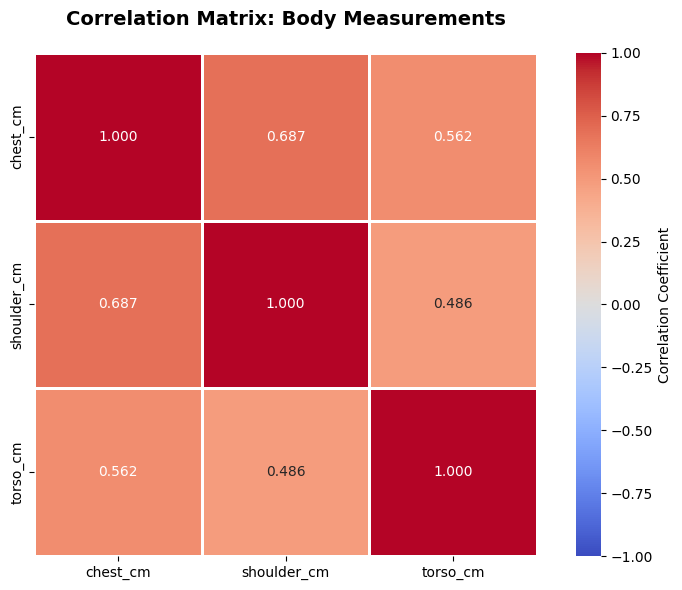


Correlation Significance Tests (p-values):
  chest_cm vs shoulder_cm: r=0.687, p=0.0000 ***
  chest_cm vs torso_cm: r=0.562, p=0.0000 ***
  shoulder_cm vs torso_cm: r=0.486, p=0.0000 ***


In [ ]:
# ============================================================================
# PART 1: CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("CORRELATION MATRIX ANALYSIS")
print("="*60)

# Calculate correlation matrix
measurements = ['chest_cm', 'shoulder_cm', 'torso_cm']
corr_matrix = df[measurements].corr()

print("\nPearson Correlation Coefficients:")
print(corr_matrix)

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, linewidths=2,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix: Body Measurements', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('day2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical significance testing
print("\nCorrelation Significance Tests (p-values):")
for i, var1 in enumerate(measurements):
    for j, var2 in enumerate(measurements):
        if i < j:  # Only upper triangle
            r, p_value = stats.pearsonr(df[var1], df[var2])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            print(f"  {var1} vs {var2}: r={r:.3f}, p={p_value:.4f} {significance}")


PAIR PLOT ANALYSIS


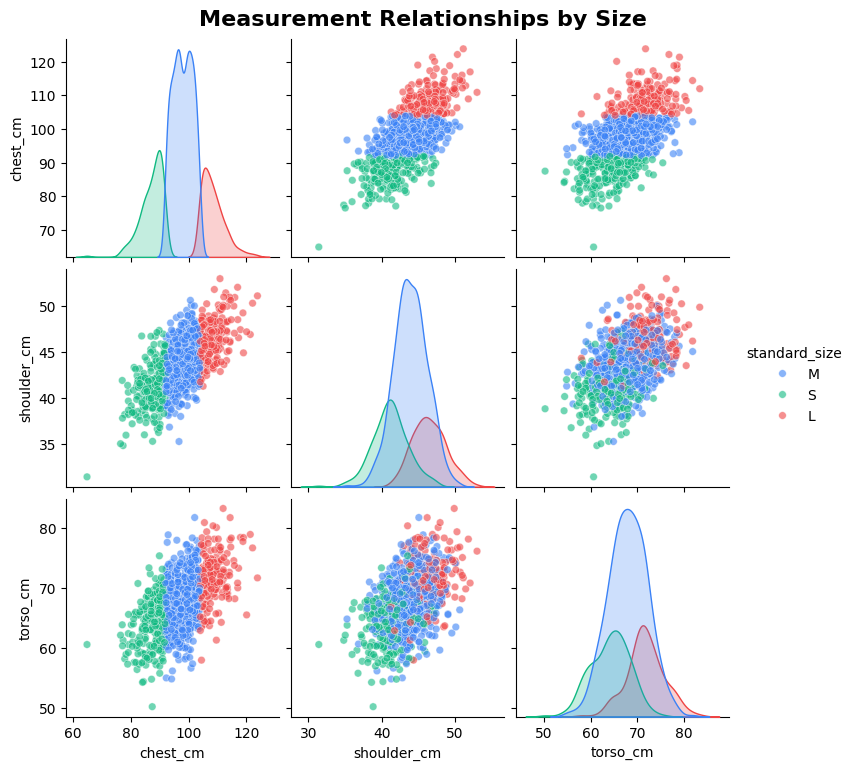


💡 Key Observation:
   Notice how size groups overlap significantly in the scatter plots.
   This overlap = customers getting wrong sizes!


In [ ]:
# ============================================================================
# PART 2: SCATTER MATRIX (PAIR PLOT)
# ============================================================================

print("\n" + "="*60)
print("PAIR PLOT ANALYSIS")
print("="*60)

# Create pair plot colored by standard size
g = sns.pairplot(df, vars=measurements, hue='standard_size',
                 palette={'S': '#10b981', 'M': '#3b82f6', 'L': '#ef4444'},
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30},
                 height=2.5)
g.fig.suptitle('Measurement Relationships by Size', y=1.02, fontsize=16, fontweight='bold')
plt.savefig('day2_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Key Observation:")
print("   Notice how size groups overlap significantly in the scatter plots.")
print("   This overlap = customers getting wrong sizes!")


OUTLIER DETECTION (Z-SCORE METHOD)

Outliers detected: 35 (3.5%)

Extreme body types (sample):
     customer_id    chest_cm  shoulder_cm   torso_cm standard_size
59            60   87.578369    35.291216  63.856382             S
69            70   96.712331    35.272314  64.887959             M
94            95   84.746399    36.002374  66.542484             S
140          141   84.431181    40.166089  54.441683             S
143          144  108.928132    51.801135  78.214275             L
157          158  114.392154    46.190648  81.800461             L
175          176  109.659558    47.681083  80.153706             L
218          219   77.937619    38.216840  58.250818             S
251          252   89.613138    36.249409  67.620761             S
254          255   78.375771    35.963515  58.972738             S


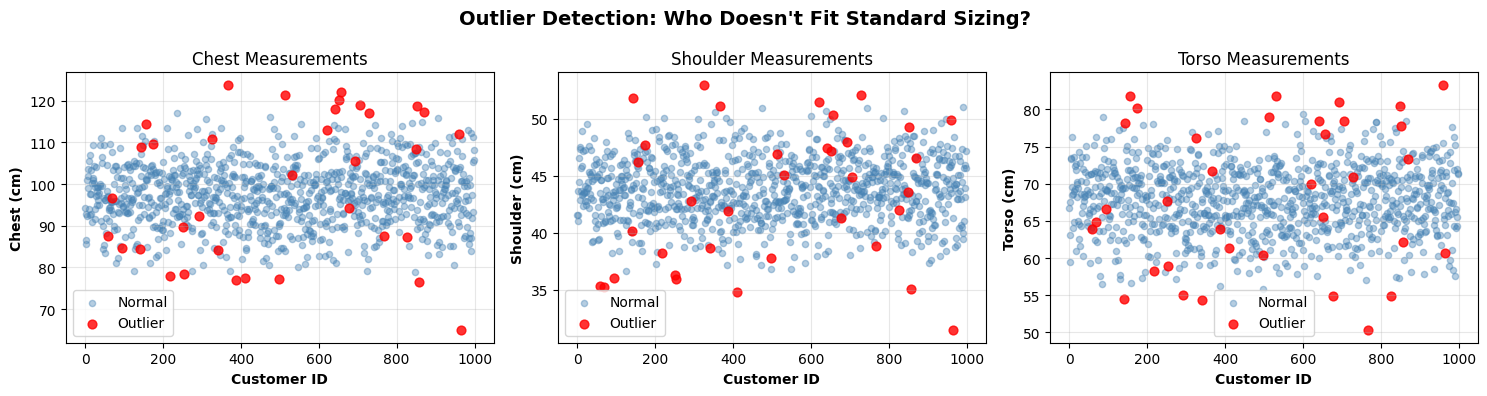

In [ ]:
# ============================================================================
# PART 3: OUTLIER DETECTION
# ============================================================================

print("\n" + "="*60)
print("OUTLIER DETECTION (Z-SCORE METHOD)")
print("="*60)

# Calculate z-scores
from scipy.stats import zscore
df['chest_zscore'] = zscore(df['chest_cm'])
df['shoulder_zscore'] = zscore(df['shoulder_cm'])
df['torso_zscore'] = zscore(df['torso_cm'])

# Identify outliers (|z| > 2.5 is unusual, |z| > 3 is extreme)
df['is_outlier'] = ((abs(df['chest_zscore']) > 2.5) |
                    (abs(df['shoulder_zscore']) > 2.5) |
                    (abs(df['torso_zscore']) > 2.5))

outliers = df[df['is_outlier']]
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
print("\nExtreme body types (sample):")
print(outliers[['customer_id', 'chest_cm', 'shoulder_cm', 'torso_cm', 'standard_size']].head(10))

# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Outlier Detection: Who Doesn\'t Fit Standard Sizing?', fontsize=14, fontweight='bold')

measurements_names = [('chest_cm', 'Chest'), ('shoulder_cm', 'Shoulder'), ('torso_cm', 'Torso')]

for ax, (col, name) in zip(axes, measurements_names):
    ax.scatter(df.index[~df['is_outlier']], df[col][~df['is_outlier']],
              alpha=0.4, s=20, color='steelblue', label='Normal')
    ax.scatter(df.index[df['is_outlier']], df[col][df['is_outlier']],
              alpha=0.8, s=40, color='red', label='Outlier')
    ax.set_xlabel('Customer ID', fontweight='bold')
    ax.set_ylabel(f'{name} (cm)', fontweight='bold')
    ax.set_title(f'{name} Measurements')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('day2_outliers.png', dpi=300, bbox_inches='tight')
plt.show()


BODY TYPE ANALYSIS

Body Type Distribution:
body_type
Average     463
Slim        236
Broad       222
Athletic     79
Name: count, dtype: int64


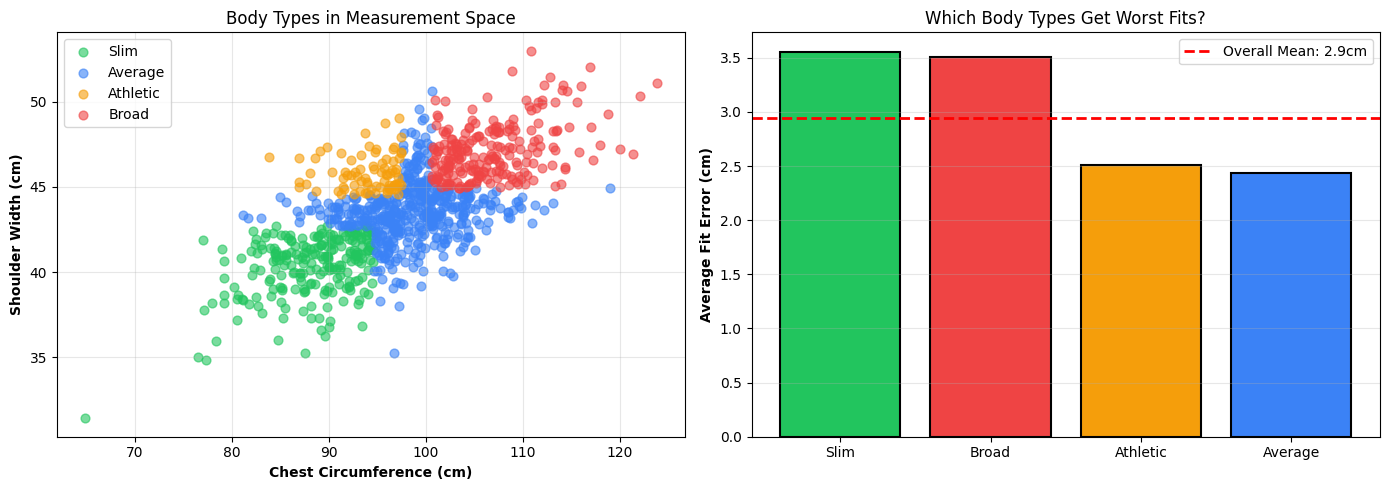


💡 Key Insight:
   'Slim' body types have 3.6cm average fit error
   vs 2.9cm overall average.
   Standard sizing is especially bad for non-average body types!


In [ ]:
# ============================================================================
# PART 4: BODY TYPE IDENTIFICATION (PRELIMINARY)
# ============================================================================

print("\n" + "="*60)
print("BODY TYPE ANALYSIS")
print("="*60)

# Define body types based on proportions
def classify_body_type(row):
    """
    Classify body types based on measurement ratios.
    - Athletic: high shoulder/chest ratio
    - Slim: below average chest, above average torso
    - Broad: high chest, average shoulder
    """
    chest_percentile = stats.percentileofscore(df['chest_cm'], row['chest_cm'])
    shoulder_percentile = stats.percentileofscore(df['shoulder_cm'], row['shoulder_cm'])

    if chest_percentile < 35 and shoulder_percentile < 35:
        return 'Slim'
    elif chest_percentile > 65 and shoulder_percentile > 65:
        return 'Broad'
    elif shoulder_percentile > 60 and chest_percentile < 50:
        return 'Athletic'
    else:
        return 'Average'

df['body_type'] = df.apply(classify_body_type, axis=1)

print("\nBody Type Distribution:")
print(df['body_type'].value_counts())

# Visualize body types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Body types in measurement space
body_type_colors = {'Slim': '#22c55e', 'Average': '#3b82f6',
                    'Athletic': '#f59e0b', 'Broad': '#ef4444'}

for body_type, color in body_type_colors.items():
    mask = df['body_type'] == body_type
    axes[0].scatter(df[mask]['chest_cm'], df[mask]['shoulder_cm'],
                   alpha=0.6, s=40, color=color, label=body_type)

axes[0].set_xlabel('Chest Circumference (cm)', fontweight='bold')
axes[0].set_ylabel('Shoulder Width (cm)', fontweight='bold')
axes[0].set_title('Body Types in Measurement Space')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Body type vs fit error
body_type_fit = df.groupby('body_type')['fit_error_cm'].mean().sort_values(ascending=False)
axes[1].bar(body_type_fit.index, body_type_fit.values,
           color=[body_type_colors[bt] for bt in body_type_fit.index],
           edgecolor='black', linewidth=1.5)
axes[1].axhline(df['fit_error_cm'].mean(), color='red', linestyle='--',
               linewidth=2, label=f'Overall Mean: {df["fit_error_cm"].mean():.1f}cm')
axes[1].set_ylabel('Average Fit Error (cm)', fontweight='bold')
axes[1].set_title('Which Body Types Get Worst Fits?')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('day2_body_types.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Key Insight:")
worst_body_type = body_type_fit.index[0]
print(f"   '{worst_body_type}' body types have {body_type_fit.iloc[0]:.1f}cm average fit error")
print(f"   vs {df['fit_error_cm'].mean():.1f}cm overall average.")
print(f"   Standard sizing is especially bad for non-average body types!")


DIMENSIONALITY ANALYSIS (PCA)

Variance Explained by Each Component:
  PC1: 72.0% (Cumulative: 72.0%)
  PC2: 17.9% (Cumulative: 89.9%)
  PC3: 10.1% (Cumulative: 100.0%)


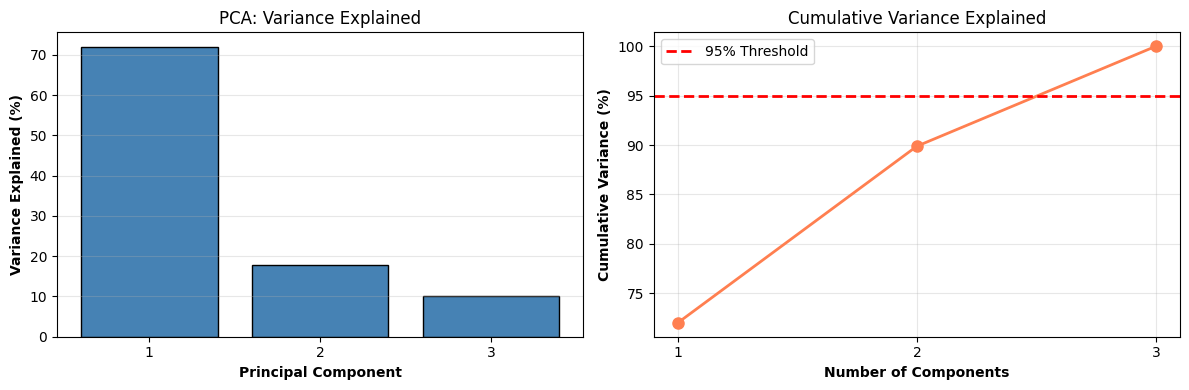


💡 Dimensionality Insight:
   72.0% of variance captured by 1st component
   89.9% captured by first 2 components
   This means measurements are highly correlated (good for sizing!)


In [ ]:
# ============================================================================
# PART 5: DIMENSIONALITY CHECK (PCA PREVIEW)
# ============================================================================

print("\n" + "="*60)
print("DIMENSIONALITY ANALYSIS (PCA)")
print("="*60)

from sklearn.decomposition import PCA

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[measurements])

# Fit PCA
pca = PCA()
pca.fit(X_scaled)

# Variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print("\nVariance Explained by Each Component:")
for i, (var, cum_var) in enumerate(zip(variance_explained, cumulative_variance), 1):
    print(f"  PC{i}: {var*100:.1f}% (Cumulative: {cum_var*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, len(variance_explained)+1), variance_explained*100,
           color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component', fontweight='bold')
axes[0].set_ylabel('Variance Explained (%)', fontweight='bold')
axes[0].set_title('PCA: Variance Explained')
axes[0].set_xticks(range(1, len(variance_explained)+1))
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance*100,
            marker='o', linewidth=2, markersize=8, color='coral')
axes[1].axhline(95, color='red', linestyle='--', linewidth=2, label='95% Threshold')
axes[1].set_xlabel('Number of Components', fontweight='bold')
axes[1].set_ylabel('Cumulative Variance (%)', fontweight='bold')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xticks(range(1, len(cumulative_variance)+1))
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('day2_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💡 Dimensionality Insight:")
print(f"   {cumulative_variance[0]*100:.1f}% of variance captured by 1st component")
print(f"   {cumulative_variance[1]*100:.1f}% captured by first 2 components")
print(f"   This means measurements are highly correlated (good for sizing!)")


In [ ]:
# ============================================================================
# PART 6: CLUSTERING READINESS CHECK
# ============================================================================

print("\n" + "="*60)
print("CLUSTERING READINESS ASSESSMENT")
print("="*60)

# Hopkins statistic (measure of clustering tendency)
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(X, sample_size=100):
    """Calculate Hopkins statistic to assess clustering tendency."""
    n, d = X.shape
    sample_size = min(sample_size, n)

    # Sample from data
    sample_indices = np.random.choice(n, sample_size, replace=False)
    X_sample = X[sample_indices]

    # Generate random points in same space
    X_random = np.random.uniform(X.min(axis=0), X.max(axis=0), (sample_size, d))

    # Nearest neighbor distances
    nbrs_sample = NearestNeighbors(n_neighbors=2).fit(X)
    dist_sample = nbrs_sample.kneighbors(X_sample)[0][:, 1]

    nbrs_random = NearestNeighbors(n_neighbors=1).fit(X)
    dist_random = nbrs_random.kneighbors(X_random)[0][:, 0]

    H = dist_random.sum() / (dist_sample.sum() + dist_random.sum())
    return H

hopkins = hopkins_statistic(X_scaled)
print(f"\nHopkins Statistic: {hopkins:.3f}")
print(f"  Interpretation:")
print(f"    H ≈ 0.5: Random data (no clusters)")
print(f"    H > 0.7: Strong clustering tendency ✅")
print(f"    H < 0.3: Regular/uniform data")

if hopkins > 0.6:
    print(f"\n✅ READY FOR CLUSTERING! Hopkins = {hopkins:.3f} indicates clear structure")
else:
    print(f"\n⚠️ Weak clustering tendency (H = {hopkins:.3f})")



CLUSTERING READINESS ASSESSMENT

Hopkins Statistic: 0.868
  Interpretation:
    H ≈ 0.5: Random data (no clusters)
    H > 0.7: Strong clustering tendency ✅
    H < 0.3: Regular/uniform data

✅ READY FOR CLUSTERING! Hopkins = 0.868 indicates clear structure


In [ ]:
# ============================================================================
# SUMMARY & NEXT STEPS
# ============================================================================

print("\n" + "="*60)
print("DAY 2 COMPLETE ✅")
print("="*60)

print("\n📊 Key Discoveries:")
print(f"1. Chest-Shoulder correlation: {corr_matrix.loc['chest_cm', 'shoulder_cm']:.3f} (Strong)")
print(f"2. Chest-Torso correlation: {corr_matrix.loc['chest_cm', 'torso_cm']:.3f} (Moderate)")
print(f"3. Outliers: {len(outliers)} customers ({len(outliers)/len(df)*100:.1f}%) need special attention")
print(f"4. Body type '{worst_body_type}' has worst fit ({body_type_fit.iloc[0]:.1f}cm avg error)")
print(f"5. Hopkins Statistic: {hopkins:.3f} → Data is ready for clustering")

print("\n🎯 Strategic Insight:")
print("   High correlation means we CAN reduce dimensions for sizing,")
print("   BUT body type variation means we NEED more than 3 sizes.")

print("\n➡️ Next Step: Run 03_kmeans_clustering.ipynb to find optimal size count")

# Export enhanced data
df.to_csv('anthropometric_data_enriched.csv', index=False)
print(f"\n✅ Enhanced data saved to 'anthropometric_data_enriched.csv'")


DAY 2 COMPLETE ✅

📊 Key Discoveries:
1. Chest-Shoulder correlation: 0.687 (Strong)
2. Chest-Torso correlation: 0.562 (Moderate)
3. Outliers: 35 customers (3.5%) need special attention
4. Body type 'Slim' has worst fit (3.6cm avg error)
5. Hopkins Statistic: 0.868 → Data is ready for clustering

🎯 Strategic Insight:
   High correlation means we CAN reduce dimensions for sizing,
   BUT body type variation means we NEED more than 3 sizes.

➡️ Next Step: Run 03_kmeans_clustering.ipynb to find optimal size count

✅ Enhanced data saved to 'anthropometric_data_enriched.csv'


In [ ]:
from google.colab import files
files.download('anthropometric_data_enriched.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>